# Pix2Pix - Image-to-Image Translation (v5.1 Final Ultimate)

Ce notebook combine le meilleur des versions précédentes pour une qualité maximale et un entrainement efficace.

## Nouveautés v5.1 (The Best of Both Worlds) :
1.  **Anti-Artifacts (v5)** : Architecture U-Net avec `Resize-Convolution` (plus de damier).
2.  **Perceptual Loss (v4/v5.1)** : Ré-intégration de la **VGGLoss** pour forcer la netteté et la texture.
3.  **Stabilité (v5)** : **Spectral Normalization** intégrale sur le Discriminateur + **Replay Buffer**.
4.  **Efficacité (v5.1)** : **Early Stopping** (Patience = 10 époques) + **Best Model Only** saving.
5.  **Hyperparamètres** : `L1=100`, `VGG=10`, `LR_G=1e-4`, `LR_D=4e-4`.

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import save_image
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

## 1. Configuration

In [12]:
class Config:
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    LR_G = 1e-4
    LR_D = 4e-4
    BATCH_SIZE = 4
    NUM_WORKERS = 4 
    IMAGE_SIZE = 256
    CHANNELS_IMG = 3
    L1_LAMBDA = 100 
    VGG_LAMBDA = 10
    NUM_EPOCHS = 100
    LOAD_MODEL = False
    SAVE_MODEL = True
    CHECKPOINT_DISC = "/kaggle/input/checkpoint/disc_v5_1.pth.tar"
    CHECKPOINT_GEN = "/kaggle/input/checkpoint/gen_v5_1.pth.tar"
    
    TRAIN_DIR = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/train"
    VAL_DIR = "/kaggle/input/pix2pix-dataset/edges2shoes/edges2shoes/val"
    
    TRAIN_SIZE_LIMIT = None 
    
print(f"Device used: {Config.DEVICE}")

Device used: cuda


## 2. Pipeline de Données

In [6]:
class Pix2PixDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        if os.path.exists(root_dir):
            self.list_files = os.listdir(root_dir)
        else:
            print(f"Attention: Le dossier {root_dir} n'existe pas.")
            self.list_files = []

    def __len__(self):
        return len(self.list_files)

    def __getitem__(self, index):
        img_file = self.list_files[index]
        img_path = os.path.join(self.root_dir, img_file)
        try:
            image = np.array(Image.open(img_path))
        except:
            return self.__getitem__(index + 1)

        w = image.shape[1]
        cutoff = w // 2
        input_image = image[:, :cutoff, :] 
        target_image = image[:, cutoff:, :]

        input_image = Image.fromarray(input_image)
        target_image = Image.fromarray(target_image)
        
        # Resize + RandomCrop
        resize = transforms.Resize((286, 286))
        input_image = resize(input_image)
        target_image = resize(target_image)
        
        i, j, h, w_crop = transforms.RandomCrop.get_params(
            input_image, output_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE)
        )
        input_image = transforms.functional.crop(input_image, i, j, h, w_crop)
        target_image = transforms.functional.crop(target_image, i, j, h, w_crop)
        
        if torch.rand(1) > 0.5:
            input_image = transforms.functional.hflip(input_image)
            target_image = transforms.functional.hflip(target_image)
            
        base_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ])
        
        input_image = base_transform(input_image)
        target_image = base_transform(target_image)

        return input_image, target_image

## 3. Utilitaires : ReplayBuffer & VGGLoss

In [7]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        self.slice = nn.Sequential()
        for i in range(35): # Layers up to ReLU5_4
            self.slice.add_module(str(i), vgg[i])
        self.slice.eval()
        for param in self.slice.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x_vgg = self.slice(x)
        y_vgg = self.slice(y)
        loss = nn.MSELoss()(x_vgg, y_vgg)
        return loss

## 4. Architecture v5 (U-Net Resize-Conv + Spectral Discriminator)

In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, act="relu", use_dropout=False):
        super().__init__()
        if down:
            self.conv = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 4, 2, 1, bias=False, padding_mode="reflect"),
                nn.InstanceNorm2d(out_channels, affine=True),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            # RESIZE-CONVOLUTION (Anti-Checkerboard)
            self.conv = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False, padding_mode="reflect"),
                nn.InstanceNorm2d(out_channels, affine=True),
                nn.ReLU(inplace=True),
            )

        self.use_dropout = use_dropout
        self.dropout = nn.Dropout(0.5)
        self.down = down

    def forward(self, x):
        x = self.conv(x)
        return self.dropout(x) if self.use_dropout else x

class Generator(nn.Module):
    def __init__(self, in_channels=3, features=64):
        super().__init__()
        self.initial_down = nn.Sequential(
            nn.Conv2d(in_channels, features, 4, 2, 1, padding_mode="reflect"),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.down1 = Block(features, features * 2, down=True, act="leaky", use_dropout=False)
        self.down2 = Block(features * 2, features * 4, down=True, act="leaky", use_dropout=False)
        self.down3 = Block(features * 4, features * 8, down=True, act="leaky", use_dropout=False)
        self.down4 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down5 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        self.down6 = Block(features * 8, features * 8, down=True, act="leaky", use_dropout=False)
        
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features * 8, features * 8, 4, 2, 1, padding_mode="reflect"),
            nn.ReLU(inplace=True),
        )

        self.up1 = Block(features * 8, features * 8, down=False, act="relu", use_dropout=True)
        self.up2 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up3 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=True)
        self.up4 = Block(features * 8 * 2, features * 8, down=False, act="relu", use_dropout=False)
        self.up5 = Block(features * 8 * 2, features * 4, down=False, act="relu", use_dropout=False)
        self.up6 = Block(features * 4 * 2, features * 2, down=False, act="relu", use_dropout=False)
        self.up7 = Block(features * 2 * 2, features, down=False, act="relu", use_dropout=False)
        
        self.final_up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(features * 2, in_channels, kernel_size=3, stride=1, padding=1, padding_mode="reflect"),
            nn.Tanh(),
        )

    def forward(self, x):
        d1 = self.initial_down(x)
        d2 = self.down1(d1)
        d3 = self.down2(d2)
        d4 = self.down3(d3)
        d5 = self.down4(d4)
        d6 = self.down5(d5)
        d7 = self.down6(d6)
        bottleneck = self.bottleneck(d7)
        u1 = self.up1(bottleneck)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        return self.final_up(torch.cat([u7, d1], 1))

class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.utils.spectral_norm(nn.Conv2d(in_channels * 2, features[0], kernel_size=4, stride=2, padding=1, padding_mode="reflect")),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                nn.Sequential(
                    nn.utils.spectral_norm(nn.Conv2d(in_channels, feature, 4, stride=1 if feature == features[-1] else 2, padding=1, bias=False, padding_mode="reflect")),
                    nn.InstanceNorm2d(feature, affine=True),
                    nn.LeakyReLU(0.2, inplace=True),
                )
            )
            in_channels = feature

        layers.append(
            nn.utils.spectral_norm(nn.Conv2d(in_channels, 1, kernel_size=4, stride=1, padding=1, padding_mode="reflect"))
        )

        self.model = nn.Sequential(*layers)

    def forward(self, x, y):
        x = torch.cat([x, y], dim=1)
        x = self.initial(x)
        return self.model(x)

## 5. Training Loop v5.1

In [9]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.kaiming_normal_(m.weight, a=0.02, mode='fan_in', nonlinearity='leaky_relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

def train_fn(disc, gen, loader, opt_disc, opt_gen, l1_loss, mse_loss, vgg_loss, g_scaler, d_scaler, replay_buffer):
    loop = tqdm(loader, leave=True)

    for idx, (x, y) in enumerate(loop):
        x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
        
        # --- Generator Forward ---
        with torch.amp.autocast('cuda'):
            y_fake = gen(x)
            D_fake = disc(x, y_fake)
            G_gan_loss = mse_loss(D_fake, torch.ones_like(D_fake))
            G_l1_loss = l1_loss(y_fake, y) * Config.L1_LAMBDA
            G_vgg_loss = vgg_loss(y_fake, y) * Config.VGG_LAMBDA
            
            G_loss = G_gan_loss + G_l1_loss + G_vgg_loss

        opt_gen.zero_grad()
        g_scaler.scale(G_loss).backward()
        g_scaler.step(opt_gen)
        g_scaler.update()
        
        # --- Discriminator Forward ---
        with torch.amp.autocast('cuda'):
            y_fake_buffer = replay_buffer.push_and_pop(y_fake.detach())
            D_real = disc(x, y)
            D_fake = disc(x, y_fake_buffer)
            
            D_real_loss = mse_loss(D_real, torch.ones_like(D_real))
            D_fake_loss = mse_loss(D_fake, torch.zeros_like(D_fake))
            D_loss = (D_real_loss + D_fake_loss) * 0.5

        opt_disc.zero_grad()
        d_scaler.scale(D_loss).backward()
        d_scaler.step(opt_disc)
        d_scaler.update()

        if idx % 10 == 0:
            loop.set_postfix(D=D_loss.item(), G=G_loss.item(), VGG=G_vgg_loss.item())

## 6. Main avec Early Stopping & Best Model Logic

In [ ]:
def validate(gen, val_loader, l1_loss):
    gen.eval()
    total_l1 = 0
    count = 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
            y_fake = gen(x)
            total_l1 += l1_loss(y_fake, y).item()
            count += 1
            if count >= 200: break # Validation rapide sur 200 samples max
    gen.train()
    return total_l1 / count if count > 0 else float('inf')

def save_some_examples(gen, val_loader, epoch, folder):
    try:
        x, y = next(iter(val_loader))
    except:
        return
    x, y = x.to(Config.DEVICE), y.to(Config.DEVICE)
    if not os.path.exists(folder):
        os.makedirs(folder)
    gen.eval()
    with torch.no_grad():
        y_fake = gen(x)
        y_fake = y_fake * 0.5 + 0.5
        x = x * 0.5 + 0.5
        y = y * 0.5 + 0.5
        save_image(y_fake, folder + f"/gen_{epoch}.png")
        save_image(x, folder + f"/input_{epoch}.png")
        save_image(y, folder + f"/label_{epoch}.png")
    gen.train()

def main():
    disc = Discriminator().to(Config.DEVICE)
    gen = Generator(features=64).to(Config.DEVICE)
    
    disc.apply(weights_init)
    gen.apply(weights_init)
    
    opt_disc = optim.Adam(disc.parameters(), lr=Config.LR_D, betas=(0.5, 0.999))
    opt_gen = optim.Adam(gen.parameters(), lr=Config.LR_G, betas=(0.5, 0.999))

    MSE_LOSS = nn.MSELoss()
    L1_LOSS = nn.L1Loss()
    VGG_LOSS = VGGLoss().to(Config.DEVICE)

    train_dataset = Pix2PixDataset(root_dir=Config.TRAIN_DIR)
    
    if Config.TRAIN_SIZE_LIMIT and len(train_dataset) > Config.TRAIN_SIZE_LIMIT:
        indices = torch.randperm(len(train_dataset))[:Config.TRAIN_SIZE_LIMIT]
        train_dataset = torch.utils.data.Subset(train_dataset, indices)

    if len(train_dataset) > 0:
        train_loader = DataLoader(
            train_dataset,
            batch_size=Config.BATCH_SIZE,
            shuffle=True,
            num_workers=Config.NUM_WORKERS,
            pin_memory=True,
        )
        val_dataset = Pix2PixDataset(root_dir=Config.VAL_DIR)
        val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False) if len(val_dataset) > 0 else train_loader

        g_scaler = torch.amp.GradScaler('cuda')
        d_scaler = torch.amp.GradScaler('cuda')
        replay_buffer = ReplayBuffer()
        
        best_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(Config.NUM_EPOCHS):
            print(f"Epoch {epoch}/{Config.NUM_EPOCHS} (Best L1: {best_val_loss:.4f}, Patience: {patience_counter}/{patience})")
            train_fn(
                disc, gen, train_loader, opt_disc, opt_gen, L1_LOSS, MSE_LOSS, VGG_LOSS, g_scaler, d_scaler, replay_buffer
            )
            
            # Validation
            current_val_loss = validate(gen, val_loader, L1_LOSS)
            print(f"Val L1 Loss: {current_val_loss:.4f}")
            
            if current_val_loss < best_val_loss:
                print("New Best Model! Saving...")
                best_val_loss = current_val_loss
                patience_counter = 0
                if Config.SAVE_MODEL:
                    torch.save(gen.state_dict(), Config.CHECKPOINT_GEN)
                    torch.save(disc.state_dict(), Config.CHECKPOINT_DISC)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"EARLY STOPPING: Pas d'amelioration depuis {patience} epoques.")
                    break
                
            if epoch % 5 == 0:
                save_some_examples(gen, val_loader, epoch, folder="evaluation")

    else:
        print("No data found.")

if __name__ == "__main__":
    main()

## 7. Inference

Meilleur modèle chargé : /kaggle/input/checkpoint/gen_v5_1.pth.tar


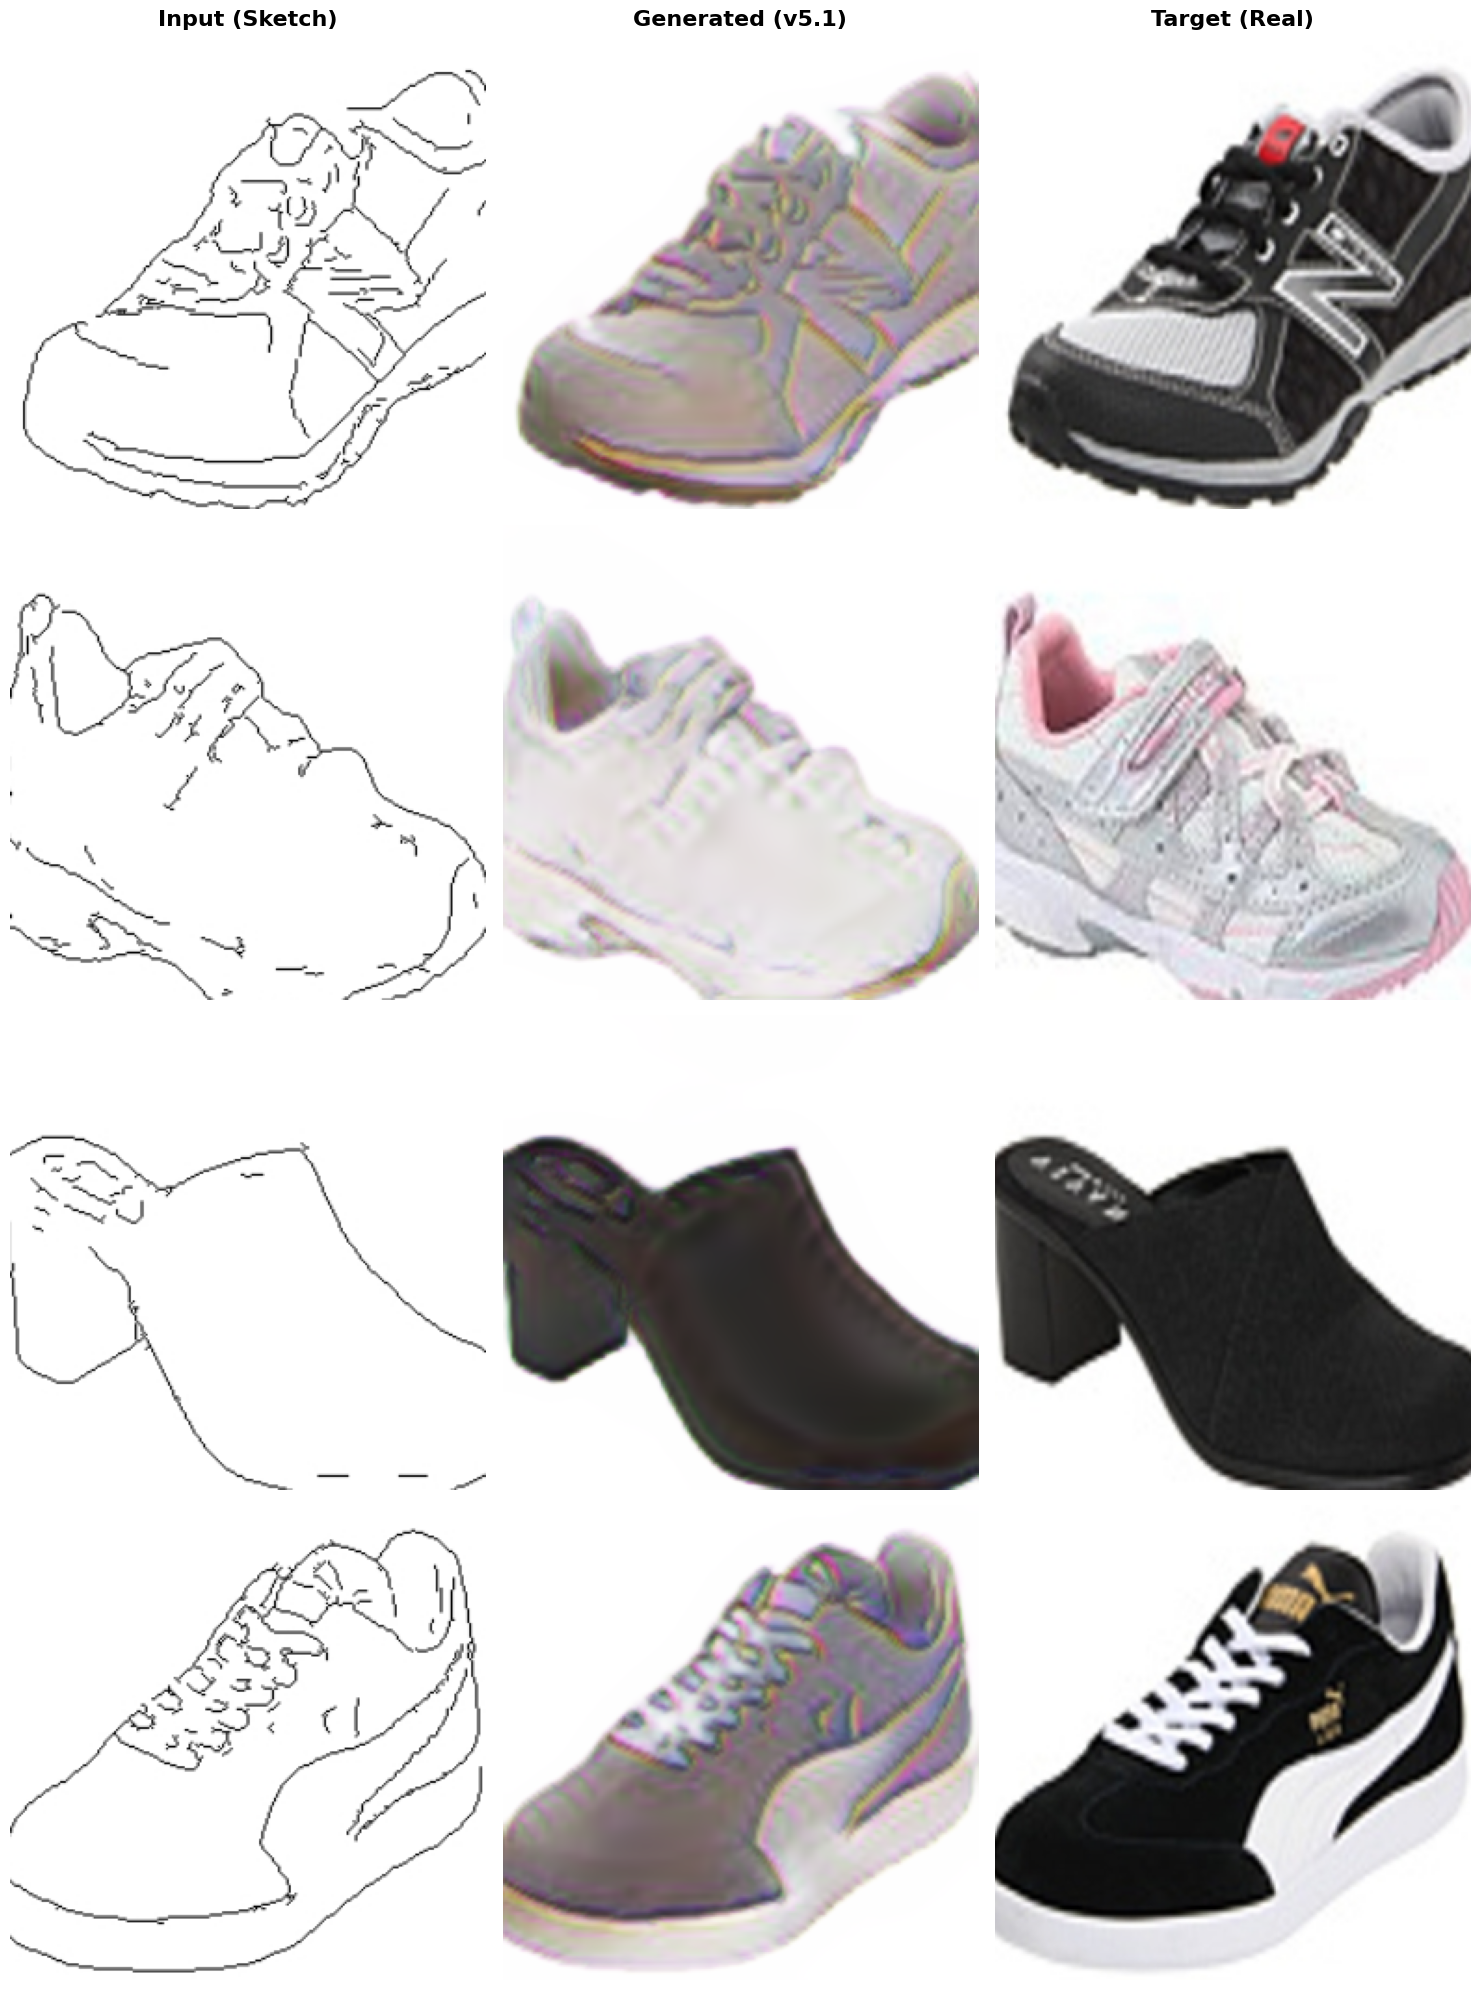

In [15]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

def display_results(num_samples=4):
    # 1. Chargement du modèle v5.1 (U-Net + Resize-Convolution)
    gen = Generator(features=64).to(Config.DEVICE)
    
    if os.path.exists(Config.CHECKPOINT_GEN):
        gen.load_state_dict(torch.load(Config.CHECKPOINT_GEN, map_location=Config.DEVICE))
        gen.eval()
        print(f"Meilleur modèle chargé : {Config.CHECKPOINT_GEN}")
    else:
        print("Erreur : Aucun checkpoint trouvé.")
        return

    # 2. Chargement des données de validation
    val_dataset = Pix2PixDataset(root_dir=Config.VAL_DIR)
    val_loader = DataLoader(val_dataset, batch_size=num_samples, shuffle=True)
    
    # Récupération d'un batch
    inputs, targets = next(iter(val_loader))
    inputs, targets = inputs.to(Config.DEVICE), targets.to(Config.DEVICE)

    # 3. Génération
    with torch.no_grad():
        fakes = gen(inputs)

    # 4. Affichage avec Matplotlib
    # Dé-normalisation de [-1, 1] vers [0, 1]
    inputs = inputs * 0.5 + 0.5
    fakes = fakes * 0.5 + 0.5
    targets = targets * 0.5 + 0.5

    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    
    # Titres des colonnes
    cols = ['Input (Sketch)', 'Generated (v5.1)', 'Target (Real)']
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, fontsize=16, fontweight='bold')

    for i in range(num_samples):
        # Image d'entrée
        axes[i, 0].imshow(inputs[i].cpu().permute(1, 2, 0))
        axes[i, 0].axis("off")
        
        # Image générée (sans brouillard de pixels)
        axes[i, 1].imshow(fakes[i].cpu().permute(1, 2, 0))
        axes[i, 1].axis("off")
        
        # Image réelle
        axes[i, 2].imshow(targets[i].cpu().permute(1, 2, 0))
        axes[i, 2].axis("off")

    plt.tight_layout()
    plt.show()

# Affichage de 4 exemples aléatoires
display_results(num_samples=4)

--- Inférence sur : /kaggle/input/shoees/shoe.png ---
Checkpoint chargé avec succès.


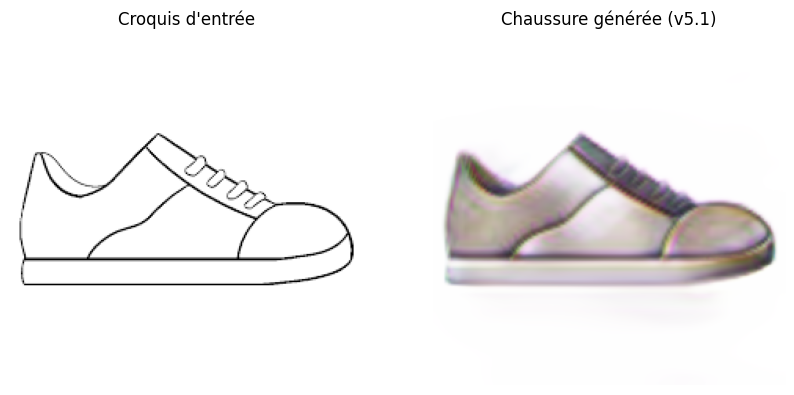

In [16]:
import os
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

def predict_custom_sketch(image_path):
    print(f"--- Inférence sur : {image_path} ---")
    
    # 1. Initialisation du Générateur v5.1 (U-Net avec Resize-Conv)
    gen = Generator(features=64).to(Config.DEVICE)
    
    # 2. Chargement des poids du meilleur modèle
    if os.path.exists(Config.CHECKPOINT_GEN):
        checkpoint = torch.load(Config.CHECKPOINT_GEN, map_location=Config.DEVICE)
        gen.load_state_dict(checkpoint)
        gen.eval()
        print("Checkpoint chargé avec succès.")
    else:
        print(f"Erreur : Checkpoint '{Config.CHECKPOINT_GEN}' introuvable.")
        return

    # 3. Préparation de l'image
    if not os.path.exists(image_path):
        print("Image introuvable à l'emplacement indiqué.")
        return
        
    img = Image.open(image_path).convert("RGB")
    
    # Transformation identique à celle de la validation
    t = transforms.Compose([
        transforms.Resize((Config.IMAGE_SIZE, Config.IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    
    x = t(img).unsqueeze(0).to(Config.DEVICE)

    # 4. Génération
    with torch.no_grad():
        # Denormalisation de [-1, 1] vers [0, 1] pour l'affichage
        res = gen(x).squeeze().cpu() * 0.5 + 0.5
        
        # Affichage côte à côte (Entrée / Sortie)
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        plt.title("Croquis d'entrée")
        plt.imshow(img)
        plt.axis("off")
        
        plt.subplot(1, 2, 2)
        plt.title("Chaussure générée (v5.1)")
        plt.imshow(res.permute(1, 2, 0))
        plt.axis("off")
        
        plt.show()

# --- TEST ---
# Remplacez ce chemin par une image de votre dossier de validation
sample_path = "/kaggle/input/shoees/shoe.png"
if os.path.exists(sample_path):
    predict_custom_sketch(sample_path)
else:
    print("Veuillez spécifier un chemin d'image valide pour le test.")